# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 3 — Exponential Families


---

Submission by:
* FirstName1, Surname1, Matrikelnummer: MatrikelnummerOfFirstTeamMember
* FirstName2, Surname2, Matrikelnummer: MatrikelnummerOfSecondTeamMember

In [1]:
import jax
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt
from numpy.typing import ArrayLike

from tueplots import bundles
from tueplots.constants.color import rgb

import abc
import functools

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

# Exercise 3.2 (Coding Exercise)

Consider the abstract base class `ExponentialFamily` introduced in the lecture (reproduced below for easy reference). 

In [2]:

import abc
import functools


class ExponentialFamily(abc.ABC):
    @abc.abstractmethod
    def sufficient_statistics(self, x: ArrayLike , /) -> jnp.ndarray:
        """Signature `(D)->(P)`"""

    @abc.abstractmethod
    def log_base_measure(self, x: ArrayLike , /) -> jnp.ndarray:
        """Signature `(D)->()`"""

    @abc.abstractmethod
    def log_partition(self, parameters: ArrayLike , /) -> jnp.ndarray:
        """Signature `(P)->()`"""

    def parameters_to_natural_parameters(
        self, parameters: ArrayLike, /
    ) -> jnp.ndarray:
        """Signature `(P)->(P)`
        In some EF's, the canonical parameters are
        actually a transformation of the natural parameters.
        In such cases, this method should be overwritten to
        provide the inverse transformation.
        """
        return jnp.asarray(parameters)

    def logpdf(
        self, x: ArrayLike , parameters: ArrayLike , /
    ) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        log p(x|parameters)
            = log h(x) + sufficient_statistics(x) @ natural_parameters - log Z(natural_parameters)
            = log base measure + linear term - log partition
        """

        x = jnp.asarray(x)
        log_base_measure = self.log_base_measure(x)
        natural_parameters = self.parameters_to_natural_parameters(parameters)
        linear_term = (
            self.sufficient_statistics(
                x)[..., None, :] @ natural_parameters[..., None]
        )[..., 0, 0]
        log_partition = self.log_partition(parameters)

        return log_base_measure + linear_term - log_partition

    def conjugate_log_partition(
        self, alpha: ArrayLike , nu: ArrayLike , /
    ) -> jnp.ndarray:
        """The log partition function of the conjugate exponential family.
        Signature `(P),()->()`
        If(!) this is available, it allows analytic construction of the conjugate prior (and thus analytic posterior inference).
        """
        raise NotImplementedError()

    def conjugate_prior(self) -> "ConjugateFamily":
        return ConjugateFamily(self)

    def predictive_log_marginal_pdf(
        self,
        x: ArrayLike,
        conjugate_natural_parameters: ArrayLike,
    ) -> jnp.ndarray:
        """ Signature `(D),(P)->()`
            log p(x|conjugate_natural_parameters)
            Your answer to Part B below should be implemented here.
        """
        alpha = conjugate_natural_parameters[0]
        nu = conjugate_natural_parameters[1]
        y = self.log_base_measure(x)+self.conjugate_log_partition(self.sufficient_statistics(x) + alpha, nu +1)-self.conjugate_log_partition(alpha, nu)
        return [y[0][0], y[1][0]]
        

    def posterior_parameters(
        self,
        prior_natural_parameters: ArrayLike ,
        data: ArrayLike ,
    ) -> jnp.ndarray:
        """Computes the natural parameters of the posterior distribution under the
        conjugate prior.
        Signature `(P),(D)->(P)`
        This can be implemented already in the abc and inherited by all subclasses,
        even if the conjugate log partition function is not available.
        (In the latter case, only the unnormalized posterior is immediately available, see below).
        """

        prior_natural_parameters = jnp.asarray(prior_natural_parameters)

        sufficient_statistics = self.sufficient_statistics(data)

        n = sufficient_statistics[..., 0].size
        expected_sufficient_statistics = jnp.sum(
            sufficient_statistics,
            axis=tuple(range(sufficient_statistics.ndim)),
        )

        alpha_prior, nu_prior = (
            prior_natural_parameters[:-1],
            prior_natural_parameters[-1],
        )

        return jnp.append(alpha_prior + expected_sufficient_statistics, nu_prior + n)


class ConjugateFamily(ExponentialFamily):
    def __init__(self, likelihood: ExponentialFamily) -> None:
        self._likelihood = likelihood

    @functools.partial(jnp.vectorize, excluded={0}, signature="(d)->(p)")
    def sufficient_statistics(self, w: ArrayLike , /) -> jnp.ndarray:
        """Signature `(D)->(P)`
        the sufficient statistics of the conjugate family are
        the natural parameters and the (negative) log partition function of the likelihood.
        """
        return jnp.append(
            self._likelihood.parameters_to_natural_parameters(w),
            -self._likelihood.log_partition(w),
        )

    def log_base_measure(self, w: ArrayLike , /) -> jnp.ndarray:
        """Signature `(D)->()`
        the base measure of the conjugate family is, implicitly, the Lebesgue measure.
        """
        w = jnp.asarray(w)

        return jnp.zeros_like(w[..., 0])

    def log_partition(
        self, natural_parameters: ArrayLike , /
    ) -> jnp.ndarray:
        """Signature `(P)->()`
        If the conjugate log partition function is available,
        we can use it to compute the log partition function of the conjugate family.
        """
        natural_parameters = jnp.asarray(natural_parameters)

        alpha, nu = natural_parameters[:-1], natural_parameters[-1]

        return self._likelihood.conjugate_log_partition(alpha, nu)

    def unnormalized_logpdf(
        self, w: ArrayLike, natural_parameters: ArrayLike , /
    ) -> jnp.ndarray:
        """Signature `(D),(P)->()`
        Even if the conjugate log partition function is not available,
        we can still compute the unnormalized log pdf of the conjugate family.
        """

        return self.sufficient_statistics(w) @ jnp.asarray(natural_parameters)

    def laplace_precision(
        self,
        natural_parameters: ArrayLike,
        mode: ArrayLike,
        /,
    ) -> jnp.ndarray:
        """Signature `(P),(D)->()`
        If the conjugate log partition function is _not_ available,
        we can still compute the Laplace approximation to the posterior,
        using only structure provided by the likelihood.
        This requires the mode of the likelihood, which is not available in general,
        but may be found by numerical optimization if necessary.
        """
        return -jax.hessian(self.unnormalized_logpdf, argnums=0)(
            jnp.asarray(mode), natural_parameters
        )

**Task A.** 

Implement a concrete realization of the binomial exponential family parametrized by log odds ratio $w = \log \frac{p}{1 - p}$, i.e.

\begin{equation*}
    p(k \mid w) = \exp \left(\log h(k) + \phi(k)^T w - \log Z(w) \right),
\end{equation*}

where

* $\log h(k) := \log \binom{n}{k}$,
* $\phi(k) := k$, and
* $\log Z(w) := n \log (1 + \exp(w))$.

(Note that $n$ is a constant in this definition, not a parameter). The normalization constant of the conjugate family

\begin{align*}
    F(\alpha, \nu)
    & := \int_{-\infty}^\infty \exp \left( \alpha w - \nu \log Z(w) \right) \mathrm{d}w \\
    & = \int_{-\infty}^\infty \exp \left( w \right)^\alpha \left( 1 + \exp(w) \right)^{-n \nu} \mathrm{d}w \\
    & = \int_0^1 \left( \frac{p}{1 - p} \right)^\alpha \left( 1 + \frac{p}{1 - p} \right)^{-n \nu} \left| \frac{1}{p (1 - p)} \right| \mathrm{d}p \\
    & = \int_0^1 p^{\alpha - 1} (1 - p)^{(n \nu - \alpha) - 1} \mathrm{d}p \\
    & = B(\alpha, n \nu - \alpha),
\end{align*}

since $p = \frac{1}{1 + \exp(-w)}$ and $\frac{\mathrm{d} p}{\mathrm{d} w} = \frac{\exp(-w)}{(1 + \exp(-w))^2} = p (1 - p)$.
This is also the normalization constant of the type VI logistic or logistic-beta distribution.

In [3]:
# thus, the following transformation is a useful utility:
def sigmoid_logpdf_transform(logpdf_logodds):
    """Transform the log-pdf of a random variable X into the
    log-pdf of the random variable sigmoid(X)"""

    def logpdf_p(ps):
        logps = jnp.log(ps)
        log1mps = jnp.log1p(-ps)
        logodds = logps - log1mps

        return logpdf_logodds(logodds) - logps - log1mps

    return logpdf_p

In [4]:
from jax.scipy.special import gammaln


In [5]:
### Your implementation of the Binomial distribution ###
from jax.scipy.special import gammaln


def log_binom(n, k):
    return gammaln(n + 1) - gammaln(k + 1) - gammaln(n - k + 1)


class BinomialLogOdds(ExponentialFamily):
    """The Binomial log oddsnk distribution."""

    def __init__(self, n) -> None:
        """The Binomial log odds has no fixed parameters."""
        super().__init__()
        self.n = n

    def sufficient_statistics(self, k: ArrayLike) -> jnp.ndarray:
        """The sufficient statistics are the identity function."""
        return jnp.asarray(k)

    def log_base_measure(self, k: ArrayLike) -> jnp.ndarray:
        k = jnp.asarray(k)
        return log_binom(self.n, k)

    def log_partition(self, w: ArrayLike) -> jnp.ndarray:
        """log Z(w) = n*log(1+exp(w))"""
        w = jnp.asarray(w)
        return self.n * jnp.log(1 + jnp.exp(w))

    def parameters_to_natural_parameters(self, w: ArrayLike) -> jnp.ndarray:
        """w = log(p/(1-p))."""
        w = jnp.asarray(w)
        return w

    # let's skip this at first glance:
    def conjugate_log_partition(self, alpha: ArrayLike, nu: ArrayLike) -> jnp.ndarray:
        """log Z(alpha, nu) = Gamma(alpha+1) / nu^{alpha+1}"""
        return (gammaln(alpha) + gammaln(self.n * nu - alpha)) - gammaln(
            alpha + (self.n * nu - alpha)
        )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


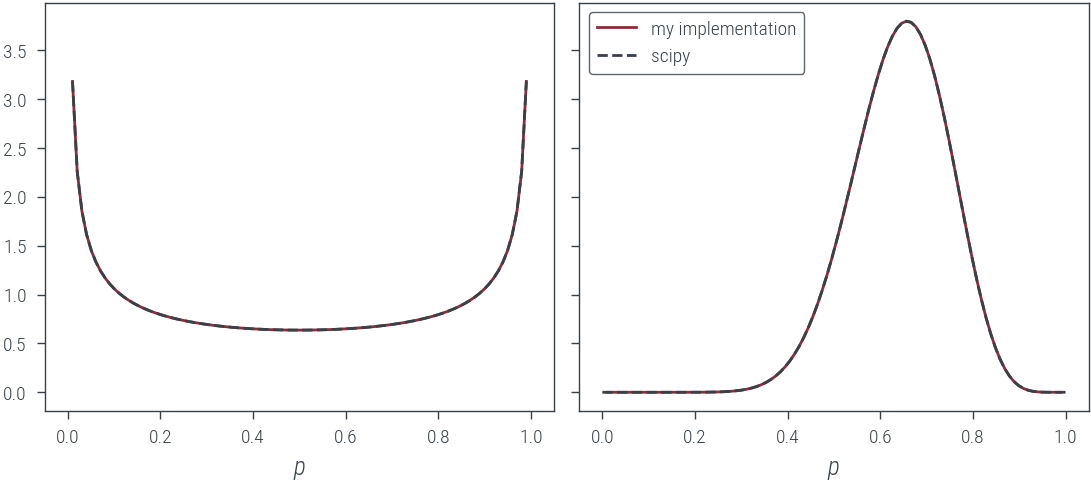

In [6]:
# Some unit tests to make sure your implementation is correct:
# instantiate your EF, and its conjugate prior:
likelihood = BinomialLogOdds(n=1)
prior = likelihood.conjugate_prior()

a, b = 0.5, 0.5
prior_natural_parameters = [
    a,  # alpha
    a + b,  # nu
]  # => Logistic-Beta(a, b)

# create some data:
key = jax.random.PRNGKey(0)
data = jax.random.bernoulli(key, 0.75, shape=(20, 1))

posterior = prior
posterior_natural_parameters = likelihood.posterior_parameters(
    prior_natural_parameters,
    data,
)


# A: Check your implementation of the conjugate prior is correctly normalized:
import scipy.integrate

np.testing.assert_allclose(
    scipy.integrate.quad(
        lambda logodds: np.exp(prior.logpdf([logodds], prior_natural_parameters)),
        -30,
        30,
    )[0],
    1.0,
    rtol=1e-5,
    err_msg="The conjugate prior is not correctly normalized.",
)

# B: check your log pdf against the scipy implementation:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
plt_ps = np.linspace(0.0, 1.0, 100)

# first for the prior:
axs[0].plot(
    plt_ps,
    jnp.exp(
        sigmoid_logpdf_transform(
            lambda logodds: prior.logpdf(logodds[..., None], prior_natural_parameters)
        )(plt_ps[..., None])
    ),
    label="my implementation",
)

axs[0].plot(plt_ps, jax.scipy.stats.beta.pdf(plt_ps, a, b), "--", label="scipy")
axs[0].set_xlabel(r"$p$")

# then for the posterior:
axs[1].plot(
    plt_ps,
    jnp.exp(
        sigmoid_logpdf_transform(
            lambda logodds: posterior.logpdf(
                logodds[..., None], posterior_natural_parameters
            )
        )(plt_ps[..., None])
    ),
    label="my implementation",
)

axs[1].plot(
    plt_ps,
    jax.scipy.stats.beta.pdf(plt_ps, a + data.sum(), b + data.size - data.sum()),
    "--",
    label="scipy",
)
axs[1].set_xlabel(r"$p$")
axs[1].legend()
plt.show()

---
**Task B.** 

Add a `predictive_log_marginal_pdf(x, natural_parameters)` function to the `ExponentialFamily` above (a placeholder has already been included). It should compute

\begin{equation*}
    \log p(x \mid \alpha, \nu) = \log \int_\mathbb{W} p(x \mid w) p(w \mid \alpha, \nu) \mathrm{d}w.
\end{equation*}
This can be explicitly implemented in the abstract base class if the `conjugate_log_partition` is available. Revisit slide 10 of Lecture 5 for reference.

In fact, it is still possible to provide this functionality **approximately** even if `conjugate_log_partition` is *not* available, using the Laplace approximation. Add a `Laplace_predictive_log_marginal(self,x,natural_parameters, mode)` function to `ExponentialFamily`, which approximates the functionality of `predictive_log_marginal` when given a `mode` $w*=\operatorname{arg\,max}_w p(w\mid \alpha,\nu)$ (compare with the `laplace_precision` function already in `ConjugateFamily`). Revisit slide 7 of Lecture 6 for reference.

Test your implementation for the concrete example of the Binomial above (for the binomial, this marginal is known as the [Beta-Binomial](https://en.wikipedia.org/wiki/Beta-binomial_distribution) distribution).

([<matplotlib.axis.XTick at 0x7f317833ef50>,
 [Text(0, 0, '0'), Text(1, 0, '1')])

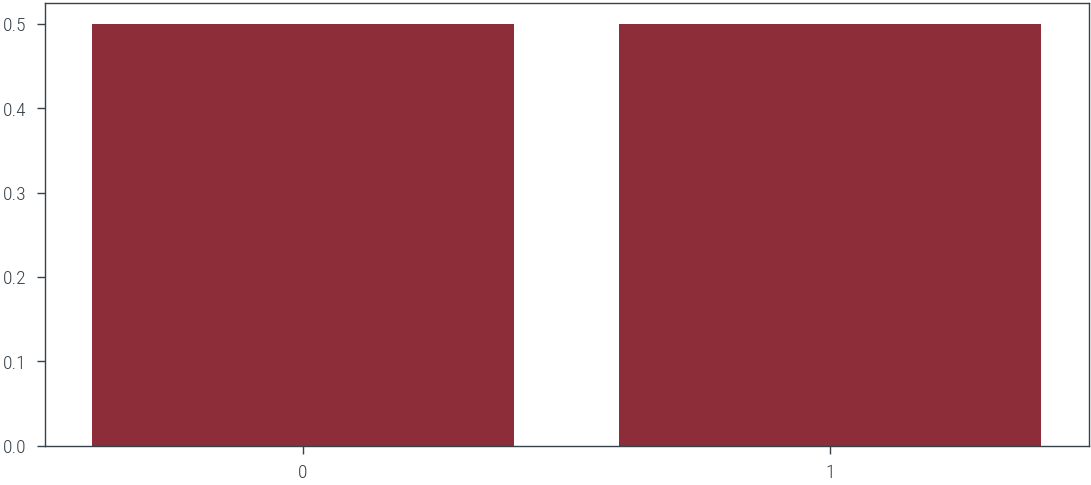

In [21]:
plt.bar(
    [0, 1], np.exp(likelihood.predictive_log_marginal_pdf(
        [[0], [1]], prior_natural_parameters))
)
plt.xticks([0, 1])

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matrikel number(s) above!)**